# Importing Libraries

In [1]:
import os
from dotenv import load_dotenv
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from einops import rearrange

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

# Huggingface
import huggingface_hub
from datasets import load_dataset

# Weights & Biases
import wandb

# Hyperparameters

In [2]:
# Patch size = P
# context size = T
# Number of patches = K = T/P
# global embedding dimension = d_G
# local embedding dimension = d_L

In [3]:
@dataclass
class CONFIG:
    debug: bool = False
    
    # Model
    V: int = 512  # 258 utf-8 characters + 2 special tokens
    P: int = 8
    T: int = 8192
    K: int = T // P  # Number of patches
    
    model_name: str = 'MEGABYTE'
    model_size: str = 'large'  # 'small' or 'large'
    
    ## Small
    if model_size == 'small':
        ### Global model
        n_layers_G: int = 6
        n_heads_G: int = 4
        d_G: int = 128
        d_head_G: int = d_G // n_heads_G
        d_ff_G: int = d_G * 4
        dropout_G: float = 0.1
        ### Local model
        n_layers_L: int = 4
        n_heads_L: int = 4
        d_L: int = 64
        d_head_L: int = d_L // n_heads_L
        d_ff_L: int = d_L * 4
        dropout_L: float = 0.1
    ### Large
    elif model_size == 'large':
        ### Global model
        n_layers_G: int = 6
        n_heads_G: int = 8
        d_G: int = 512
        d_head_G: int = d_G // n_heads_G
        d_ff_G: int = d_G * 4
        dropout_G: float = 0.1
        ### Local model
        n_layers_L: int = 6
        n_heads_L: int = 4
        d_L: int = 256
        d_head_L: int = d_L // n_heads_L
        d_ff_L: int = d_L * 4
        dropout_L: float = 0.1
    
    flash_attention: bool = False
    
    # Vocabulary
    PAD_ID: int = 256
    EOS_ID: int = 257
    
    # data
    validation_size: float = 0.1
    shakespeare_id = "data/shakespeare.txt"
    wiki_id = "wikimedia/wikipedia"
    dataset_id = shakespeare_id
    
    # Device
    device: torch.device = None
    
    # Training
    epochs: int = 1
    batch_size: int = 4
    learning_rate: float = 2e-4
    
    # Generation
    max_len: int = 10000
    temperature: float = 1.0
    
    # Seed
    seed: int = 101

# Reproducibility

In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print(f"Seed: {seed}")
    
set_seed(CONFIG.seed)

Seed: 101


# Device

In [5]:
def configure_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        num_gpu = torch.cuda.device_count()
        print("> Running on GPU", end=' | ')
        print("Num of GPUs: ", num_gpu)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("> Running on MPS")
    else:
        device = torch.device("cpu")
        print("> Running on CPU")
    return device

CONFIG.device = configure_device()

> Running on GPU | Num of GPUs:  1


# Debug

In [6]:
if CONFIG.debug:
    CONFIG.model_size = 'small'
    CONFIG.dataset_id = "data/shakespeare.txt"
    CONFIG.epochs = 1
    CONFIG.max_len = 2000

# HuggingFace

In [7]:
#if not CONFIG.debug:
#    load_dotenv()
#    token = os.getenv("HUGGINGFACE_TOKEN")
#    huggingface_hub.login(token=token, add_to_git_credential=True)

# Weights & Biases

In [8]:
#if not CONFIG.debug:
#    api_key = os.getenv("WANDB_API_KEY")
#    wandb.login(key=api_key)
#    wandb.init(project=CONFIG.model_name)

# Dataset

## Shakespeare

In [9]:
def load_shakespeare():
    with open(CONFIG.shakespeare_id, 'r') as f:
        shakespeare_text = f.read()
    return shakespeare_text

shakespeare_text = load_shakespeare()

In [10]:
print(shakespeare_text[:1000])
print(f'Total number of characters in the text: {len(shakespeare_text)}')

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## Wikipedia

In [11]:
#wiki_dataset = load_dataset(CONFIG.wiki_id, "20231101.en")

In [12]:
#wiki_dataset

In [13]:
#print(wiki_dataset['train']['text'][0][:1000])

# Tokenization

In [14]:
char2int = {chr(i): i for i in range(CONFIG.V)}
int2char = {i: chr(i) for i in range(CONFIG.V)}

# Add special tokens
char2int['<PAD>'] = CONFIG.PAD_ID
int2char[CONFIG.PAD_ID] = '<PAD>'
char2int['<EOS>'] = CONFIG.EOS_ID
int2char[CONFIG.EOS_ID] = '<EOS>'

# Encoding and Decoding
encode = lambda text: [char2int[c] for c in text]
decode = lambda tokens: ''.join([int2char[t] for t in tokens])

In [15]:
sample_text = "Hello, World!" + "<EOS>"
sample_tokens = encode(sample_text)
print(sample_tokens)
print(decode(sample_tokens))

[72, 101, 108, 108, 111, 44, 32, 87, 111, 114, 108, 100, 33, 60, 69, 79, 83, 62]
Hello, World!<EOS>


# Preprocessing

In [16]:
def preprocess(dataset_id):
    if dataset_id == CONFIG.shakespeare_id:
        text = load_shakespeare()
    elif dataset_id == CONFIG.wiki_id:
        text = wiki_dataset['train']['text']
    else:
        raise ValueError("Invalid dataset id")
    tokens = torch.tensor(encode(text), dtype=torch.long)
    return tokens

dataset_tokens = preprocess(CONFIG.dataset_id)

In [17]:
def train_validation_split(tokens, validation_size):
    train_size = int(len(tokens) * (1 - validation_size))
    return tokens[:train_size], tokens[train_size:]

train_tokens, validation_tokens = train_validation_split(dataset_tokens, CONFIG.validation_size)

In [18]:
print(f'Train size: {len(train_tokens)}')
print(f'Validation size: {len(validation_tokens)}')

Train size: 1003854
Validation size: 111540


In [19]:
class TextDataset(Dataset):
    def __init__(self, tokens, context_length):
        self.tokens = tokens
        self.context_length = context_length
        
    def __len__(self):
        return len(self.tokens) - self.context_length
    
    def __getitem__(self, idx):
        return self.tokens[idx:idx+self.context_length], self.tokens[idx+1:idx+self.context_length+1]

In [20]:
def create_dataloader(train_tokens, validation_tokens, context_length, batch_size):
    train_dataset = TextDataset(train_tokens, context_length)
    validation_dataset = TextDataset(validation_tokens, context_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, validation_loader

train_loader, validation_loader = create_dataloader(train_tokens, validation_tokens, CONFIG.T, CONFIG.batch_size)

In [21]:
sample_x, sample_y = next(iter(train_loader))
sample_x, sample_y = sample_x.to(CONFIG.device), sample_y.to(CONFIG.device)
print(sample_x.shape, sample_y.shape)
print(sample_x[0])
print(sample_y[0])

torch.Size([4, 8192]) torch.Size([4, 8192])
tensor([ 32, 115, 111,  ...,  72,  69,  82], device='cuda:0')
tensor([115, 111, 110,  ...,  69,  82,  77], device='cuda:0')


# Model

## Transformer

In [22]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_embed: int, n_heads: int, d_head: int):
        super().__init__()
        self.d_embed = d_embed
        self.n_heads = n_heads
        self.d_head = d_head
        
        self.query = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.key = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.value = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.out = nn.Linear(self.n_heads * self.d_head, self.d_embed, bias=False)
        
    def forward(self, x):  # [batch_size, context_size, d_embed]
        batch_size, context_size, _ = x.size()
        q = self.query(x).view(batch_size, context_size, self.n_heads, self.d_head)  # [batch_size, context_size, n_heads, d_head]
        k = self.key(x).view(batch_size, context_size, self.n_heads, self.d_head)  # [batch_size, context_size, n_heads, d_head]
        v = self.value(x).view(batch_size, context_size, self.n_heads, self.d_head)  # [batch_size, context_size, n_heads, d_head]
        
        q = q.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        k = k.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        v = v.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        
        # Masked Self Attention
        mask = torch.triu(torch.ones(context_size, context_size, device=x.device), diagonal=1).bool()  # [context_size, context_size]
        mask = mask.view(1, 1, context_size, context_size)  # [1, 1, context_size, context_size]
        mask = mask.repeat(batch_size, self.n_heads, 1, 1)  # [batch_size, n_heads, context_size, context_size]
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_head ** 0.5)  # [batch_size, n_heads, context_size, context_size]
        scores = scores.masked_fill(mask, float('-inf'))  # [batch_size, n_heads, context_size, context_size]
        scores = F.softmax(scores, dim=-1)  # [batch_size, n_heads, context_size, context_size]
        
        x = torch.matmul(scores, v)  # [batch_size, n_heads, context_size, d_head]
        x = x.transpose(1, 2).contiguous().view(batch_size, context_size, self.n_heads * self.d_head)  # [batch_size, context_size, n_heads * d_head]
        x = self.out(x)  # [batch_size, context_size, d_embed]
        return x

In [23]:
class MLP(nn.Module):
    def __init__(self, d_embed: int, d_ff: int, dropout: float):
        super().__init__()
        self.dropout = dropout
        
        self.fc1 = nn.Linear(d_embed, d_ff, bias=False)
        self.fc2 = nn.Linear(d_ff, d_embed, bias=False)
        
    def forward(self, x):  # [batch_size, context_size, d_embed]
        x = F.gelu(self.fc1(x))  # [batch_size, context_size, d_ff]
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)  # [batch_size, context_size, d_embed]
        return x

In [24]:
class Decoder(nn.Module):
    def __init__(self, n_heads: int, d_head: int, d_embed: int, d_ff: int, dropout: float):
        super().__init__()
        self.attention = CausalSelfAttention(d_embed=d_embed, n_heads=n_heads, d_head=d_head)
        self.norm1 = nn.LayerNorm(d_embed)
        
        self.mlp = MLP(d_embed=d_embed, d_ff=d_ff, dropout=dropout)
        self.norm2 = nn.LayerNorm(d_embed)
        
    def forward(self, x):  # [batch_size, context_size, d_embed], [batch_size, num_patches, patch_size * d_embed], [batch_size * num_patches, patch_size, local_d_embed]
        x = x + self.attention(self.norm1(x))  # [batch_size, context_size, d_embed], [batch_size, num_patches, patch_size * d_embed], [batch_size * num_patches, patch_size, local_d_embed]
        x = x + self.mlp(self.norm2(x))  # [batch_size, context_size, d_embed], [batch_size, num_patches, patch_size * d_embed], [batch_size * num_patches, patch_size, local_d_embed]
        return x

## MEGABYTE

In [25]:
class PatchEmbedder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config.V, config.d_G)
        self.positional_embedding = nn.Embedding(config.T, config.d_G)
        
    def forward(self, bytes):  # [batch_size, context_size]
        assert self.config.T % self.config.P == 0, "context size must be divisible by patch size"
        
        bytes = self.embedding(bytes) + self.positional_embedding(torch.arange(self.config.T, device=bytes.device))  # [batch_size, context_size, d_embed]
        bytes = rearrange(bytes, "b (k p) d -> b k (p d)", b=bytes.shape[0], k=self.config.K, p=self.config.P, d=self.config.d_G)  # [batch_size, num_patches, patch_size * d_embed]
        return bytes

In [26]:
class GlobalModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embedder = PatchEmbedder(config)
        self.decoder = Decoder(n_heads=config.n_heads_G, d_head=config.d_head_G, d_embed=config.P*config.d_G, d_ff=config.d_ff_G, dropout=config.dropout_G)
        self.linear = nn.Linear(config.d_G, config.d_L, bias=False)
        
    def forward(self, bytes):  # [batch_size, context_size]
        x = self.patch_embedder(bytes)  # [batch_size, num_patches, patch_size * d_embed]
        for _ in range(self.config.n_layers_G):
            x = self.decoder(x)  # [batch_size, num_patches, patch_size * d_embed]
        x = rearrange(x, "b k (p d) -> (b k) p d", b=bytes.shape[0], k=self.config.K, p=self.config.P, d=self.config.d_G)  # [batch_size * num_patches, patch_size, d_embed]
        x = self.linear(x)  # [batch_size * num_patches, patch_size, local_d_embed]
        return x

In [27]:
class LocalModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config.V, config.d_L)
        self.local_transformer = Decoder(n_heads=config.n_heads_L, d_head=config.d_head_L, d_embed=config.d_L, d_ff=config.d_ff_L, dropout=config.dropout_L)
        self.linear = nn.Linear(config.d_L, config.V, bias=False)
        
    def forward(self, local_input, global_output):  # [batch_size * num_patches, patch_size], [batch_size * num_patches, patch_size, local_d_embed]
        x = self.embedding(local_input) + global_output  # [batch_size * num_patches, patch_size, local_d_embed]
        for _ in range(self.config.n_layers_L):
            x = self.local_transformer(x)  # [batch_size * num_patches, patch_size, local_d_embed]
        x = self.linear(x)  # [batch_size * num_patches, patch_size, vocab_size]
        x = rearrange(x, "(b k) p v -> b (k p) v", k=self.config.K, p=self.config.P, v=self.config.V)  # [batch_size, context_size, vocab_size]
        return x

In [28]:
class MEGABYTE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.global_model = GlobalModel(config)
        self.local_model = LocalModel(config)
        self.max_len = config.max_len
        self.context_size = config.T
        self.temperature = config.temperature
        
    def forward(self, bytes):  # [batch_size, context_size]
        global_input, local_input = self.prepare_input(bytes)  # [batch_size, context_size], [batch_size * num_patches, patch_size]
        global_output = self.global_model(global_input)  # [batch_size * num_patches, patch_size, local_d_embed]
        local_output = self.local_model(local_input, global_output)  # [batch_size, context_size, vocab_size]
        return local_output
        
    def prepare_input(self, bytes):  # [batch_size, context_size]
        global_padding = bytes.new(bytes.shape[0], self.config.P).fill_(self.config.PAD_ID)  # [batch_size, patch_size]
        global_input = torch.cat((global_padding, bytes[:, :-self.config.P]), dim=-1)  # [batch_size, context_size]
        
        bytes_input = rearrange(bytes, "b (k p) -> (b k) p", p=self.config.P)  # [batch_size * num_patches, patch_size]
        local_padding = bytes_input.new(bytes_input.shape[0], 1).fill_(self.config.PAD_ID)  # [patch_size]
        local_input = torch.cat((local_padding, bytes_input[:, :-1]), dim=-1)  # [batch_size * num_patches, patch_size]
        return global_input, local_input
    
    def loss(self, bytes, y):  # y: [batch_size, context_size]
        y = rearrange(y, "b t -> (b t)")  # [batch_size * context_size]
        logits = self.forward(bytes)  # [batch_size, context_size, vocab_size]
        logits = rearrange(logits, "b t v -> (b t) v", v=self.config.V)  # [batch_size * context_size, vocab_size]
        return F.cross_entropy(logits, y, ignore_index=self.config.PAD_ID)
    
    @torch.no_grad()
    def generate(self, bytes, max_len=None, decode_fn=None):
        self.eval()
        if max_len is None:
            max_len = self.max_len
    
        for _ in range(max_len - bytes.size(1)):  # x: [batch_size, context]
            context = bytes[:, -self.context_size:]  # [batch_size, context_size]
            output = self.forward(context)  # [batch_size, context_size, vocab_size]
            logits = output[:, -1, :] / self.temperature
            next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(-1)  # [batch_size]
            bytes = torch.cat((bytes, next_token.unsqueeze(-1)), dim=-1)  # [batch_size, context]
    
            # Decode token
            if decode_fn is not None:
                decoded_token = decode_fn([next_token[0].item()])
                print(decoded_token, end='', flush=True)
                
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())
    
    def get_global_params(self):
        return self.global_model.parameters()
    
    def get_local_params(self):
        return self.local_model.parameters()

In [29]:
megabyte = MEGABYTE(CONFIG).to(CONFIG.device)
print(megabyte)
# number of parameters in millions
print(f'Number of parameters: {megabyte.get_num_params() / 1e6:.2f}M')
print(f'Number of global parameters: {sum(p.numel() for p in megabyte.get_global_params()) / 1e6:.2f}M')
print(f'Number of local parameters: {sum(p.numel() for p in megabyte.get_local_params()) / 1e6:.2f}M')

MEGABYTE(
  (global_model): GlobalModel(
    (patch_embedder): PatchEmbedder(
      (embedding): Embedding(512, 512)
      (positional_embedding): Embedding(8192, 512)
    )
    (decoder): Decoder(
      (attention): CausalSelfAttention(
        (query): Linear(in_features=4096, out_features=512, bias=False)
        (key): Linear(in_features=4096, out_features=512, bias=False)
        (value): Linear(in_features=4096, out_features=512, bias=False)
        (out): Linear(in_features=512, out_features=4096, bias=False)
      )
      (norm1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=4096, out_features=2048, bias=False)
        (fc2): Linear(in_features=2048, out_features=4096, bias=False)
      )
      (norm2): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
    )
    (linear): Linear(in_features=512, out_features=256, bias=False)
  )
  (local_model): LocalModel(
    (embedding): Embedding(512, 256)
    (local_transfo

In [30]:
loss = megabyte.loss(sample_x, sample_y)
print(loss)

megabyte.generate(sample_x, max_len=CONFIG.T+1, decode_fn=decode)

tensor(6.9080, device='cuda:0', grad_fn=<NllLossBackward0>)
s

# Training

In [31]:
def train(model):
    model = model.to(CONFIG.device)
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG.learning_rate)
    
    train_loss = []
    validation_loss = []
    
    for epoch in range(CONFIG.epochs):
        model.train()
        running_loss = 0.0
        for x, y in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{CONFIG.epochs}'):
            x, y = x.to(CONFIG.device), y.to(CONFIG.device)
            optimizer.zero_grad()
            loss = model.loss(x, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss.append(running_loss / len(train_loader))
        print(f'Training Loss: {running_loss / len(train_loader)}')
        
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for x, y in validation_loader:
                x, y = x.to(CONFIG.device), y.to(CONFIG.device)
                loss = model.loss(x, y)
                running_loss += loss.item()
                
        validation_loss.append(running_loss / len(validation_loader))
        print(f'Validation Loss: {running_loss / len(validation_loader)}')
        
    plt.plot(train_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/1: 100%|██████████| 248916/248916 [17:29:39<00:00,  3.95it/s]  


Training Loss: 0.33928113404260507
Validation Loss: 8.391607353237616


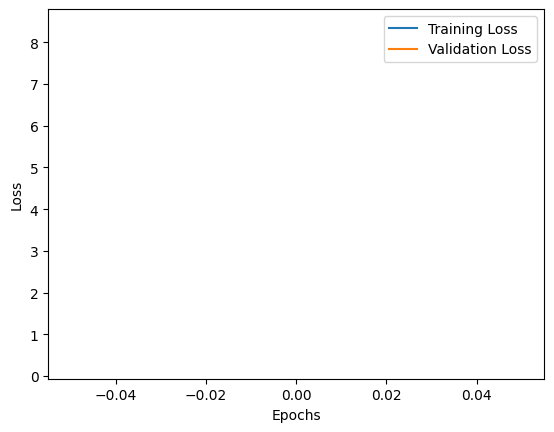

In [32]:
train(model=megabyte)

# Inference

In [33]:
megabyte.generate(sample_x, decode_fn=decode)

MIONE:
To tell, he longs to see his mouth: thin  oatssdhipg somn mostegae tseufhdstuniarsLmWn tnigptledLsw rnuts ,nmund myewrI swyan hwnrw 
uog oo  oun sntmhr eore
toll teops  'fmrmsmtla ;hbssylti.e
whucn dose yauley -oi
ent na'er aodniieg.a
,otiment  not
aoa Cerilt nfbrewdntsa
,awhhl ,hwuktlb  otres
,id goaasyo  oath -alpaaser lndkt,ii. LTnlr ndwelh raohs

ruat  oa hese;tWilt nhwlyo 
nlwonts  henc.,
Bhelhaa,dat,hautto,,mdd mokt see oWe
lnn  hanh oh  iclaa dlswreteh af rvsraeo
.oBvtnos,fg tnesy,io 
ale io vhs'a uepen t omhr
whoteet a  aotr sluv,
O rad olt hosbmert
nsver wtel  ow you snensteo snceesI cheor ropln.TNywtlh  aooh
mtnre
tvls meenwr toasf to rhsoota ehtlgr't
msslnpforc: then d
 regoon aobyyd oun taake  oon dhamh
mvlstrpcsaeias 
 fmorhum desian soel afddanei ylur,.E
ftr aob eoml nith rsvaxte
hfserci ynucbiogsIat

heu  dprntsatt
e desdeds uho
torcelvsswtro govd
eibhery oi  todcssoa'i  lone. Bhtm not Ivfr
toer eoet  itsefsrotefieitg d aatitgnnyt rnsoaoh;
teel tia  eattee  sllunn

# Evaluation